**CNC Tool Wear Prediction using Machine Learning**

 Tool wear directly impacts machining quality, productivity, and maintenance costs in modern manufacturing. Traditional monitoring relies on manual inspection or fixed schedules, which often leads to either premature tool changes or unexpected failures.

In this project, we use machine learning to predict tool wear states (Usable vs Worn) from real machining data. The dataset includes operating conditions (spindle speed, feed rate, depth of cut), sensor readings (load, temperature), and machine/tool metadata.

**Key Steps in the Workflow:**

1. Feature Engineering: Transform raw logs into meaningful indicators of tool health (e.g., cumulative usage, material removal rate, thermal slope, load variation).

2. Multicollinearity Check: Use correlation heatmaps and Variance Inflation Factor (VIF) to prune redundant features.

3. Model Training: Benchmark three algorithms — Logistic Regression (interpretable baseline), Random Forest, and XGBoost (non-linear, powerful learners).

**Evaluation:** Compare models using confusion matrices, classification metrics, ROC curves, and AUC scores.

**Interpretability:** Examine feature importance to understand which signals drive wear most strongly.

**Goal:**

To build a predictive pipeline that not only identifies worn tools accurately but also explains why predictions are made — making it easier to integrate into CNC monitoring systems and assist operators in decision-making.

In [ ]:
# Install extra packages (if not already in Colab)
!pip install xgboost seaborn --quiet

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, roc_auc_score
)

# Show plots inline
%matplotlib inline

# Load dataset
# replace the path with your uploaded CSV file
df = pd.read_csv("cnc_tool_wear.csv")

# Quick look at data
print(df.shape)
df.head()

(100000, 14)


,tool_id,tool_name,machine_id,machine_name,machine_type,machine_age_years,shift,hours_run,spindle_load,vibration,temperature,coolant_on,material_type,tool_worn
0,79,Tool_79,11,Machine_011,Lathe,8,Night,71.83,83.87,3.809000,38.77,0,Brass,0
1,84,Tool_84,35,Machine_035,Lathe,10,Night,49.23,75.11,4.811000,62.33,0,Titanium,1
2,21,Tool_21,39,Machine_039,Lathe,9,Night,40.69,72.44,3.854000,44.27,0,Brass,0
3,86,Tool_86,7,Machine_007,HMC,10,Night,65.23,122.66,3.202071,56.31,0,Steel,0
4,36,Tool_36,15,Machine_015,Lathe,13,Night,64.59,75.59,6.347000,62.69,0,Aluminum,0


**EDA – What This Cell Does**


*   Class Balance

    1. Counts how many tools are in Usable vs Worn states.

      2. Plots a bar chart for visual balance check (important for ML split & resampling).
*   Missing Values Check


*   Summary Statistics
*  Feature Distributions

**Histogram Axes**

**X-axis (horizontal):**

Represents the values of the feature you’re plotting.

Example: if plotting spindle_load, the x-axis might range from 0% to 100%.

If plotting vibration, it might go from 0 to 20 (depending on your data).

Each “bin” on the x-axis is an interval of values (e.g., 0–10, 10–20).

**Y-axis (vertical):**

Represents the frequency (count) of records that fall into each bin.

Example: if 3000 tools had temperature between 30–40°C, the bar for that bin will rise to 3000.





Tool Wear Distribution:
tool_worn
0    70219
1    29781
Name: count, dtype: int64


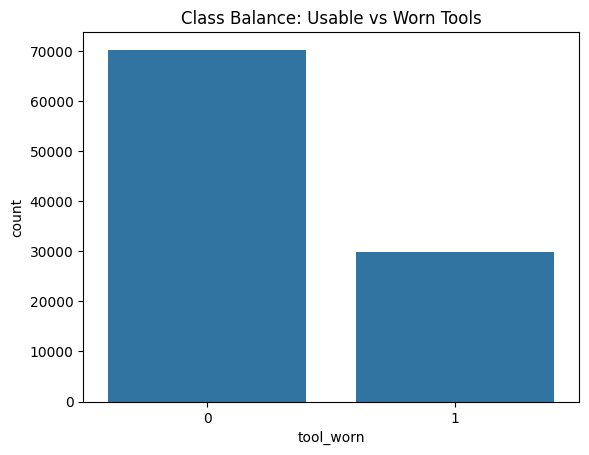


Missing Values per Column:
tool_id                 0
tool_name               0
machine_id              0
machine_name            0
machine_type            0
machine_age_years       0
shift                   0
hours_run               0
spindle_load         5000
vibration            5000
temperature          5000
coolant_on              0
material_type           0
tool_worn               0
dtype: int64

Summary Statistics:


,count,mean,std,min,25%,50%,75%,max
tool_id,100000.0,50.511180,28.922112,1.000000,25.000,51.000,76.000,100.000000
machine_id,100000.0,25.424830,14.446611,1.000000,13.000,25.000,38.000,50.000000
machine_age_years,100000.0,7.504110,4.029244,1.000000,4.000,7.000,11.000,14.000000
hours_run,100000.0,49.843609,15.104359,-11.670000,39.840,50.020,60.000,113.100000
spindle_load,95000.0,69.978927,19.993691,-17.730000,56.460,70.030,83.490,156.580000
vibration,95000.0,5.250173,4.316371,-29.783504,3.653,5.012,6.375,111.245469
temperature,95000.0,59.962989,9.989587,12.830000,53.260,59.940,66.680,102.770000
coolant_on,100000.0,0.500740,0.500002,0.000000,0.000,1.000,1.000,1.000000
tool_worn,100000.0,0.297810,0.457298,0.000000,0.000,0.000,1.000,1.000000


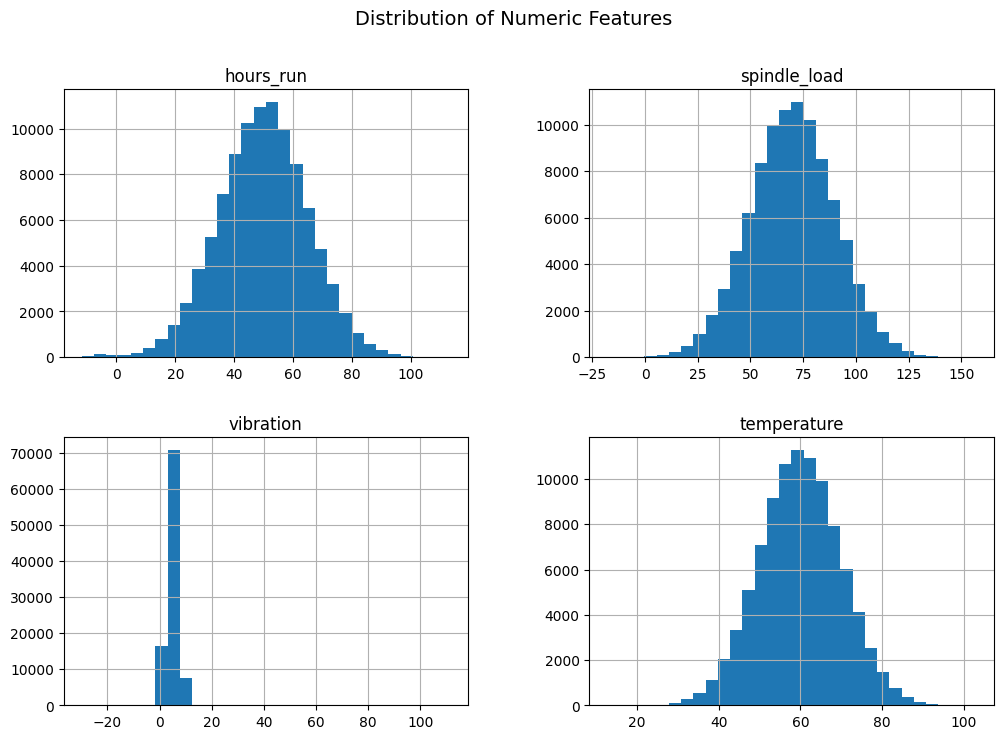

In [ ]:
#  EDA for CNC Tool Wear Dataset

target_col = "tool_worn"   # wear status column

# Class balance
print("Tool Wear Distribution:")
print(df[target_col].value_counts())

sns.countplot(x=target_col, data=df)
plt.title("Class Balance: Usable vs Worn Tools")
plt.show()

# Missing values check
print("\nMissing Values per Column:")
print(df.isnull().sum())

# Summary statistics
print("\nSummary Statistics:")
display(df.describe().T)

# Distribution plots for key sensor/operational columns
numeric_cols = ["hours_run", "spindle_load", "vibration", "temperature"]

df[numeric_cols].hist(figsize=(12,8), bins=30)
plt.suptitle("Distribution of Numeric Features", fontsize=14)
plt.show()



**Feature Engineering**
1. **hours_cumulative (Tool Usage / Age):** Tools wear as they are used over time. The longer a tool has been in service, the higher the probability of wear, regardless of the machining condition. Gives a baseline measure of tool life progression.

2. **cycle_index (Cycle Count):** Each cutting cycle removes material and contributes to wear. Even if conditions vary, more cycles → more chances for edge dulling, cracks, or chipping.


    *  In CNC machining, a cycle is one complete operation or machining pass.

        Example:

        Load tool → cut a part (milling, drilling, turning, etc.) → unload part.

        That full sequence = 1 cycle.

        So for each tool_id, the data records repeated cycles of use.

3. **temp_slope (Thermal Trend):**  Tool wear leads to higher friction → more heat. Not just temperature value, but the rate of increase is critical. A steep slope means the tool is deteriorating quickly.

    Early warning signal. Even if absolute temp is “normal,” a rising slope indicates trouble.

  4. load_variation (Mechanical Stability): A sharp, stable tool cuts smoothly → load stays consistent. A worn tool causes chatter, uneven cutting → fluctuating load. Using a dull knife: sometimes it cuts, sometimes it gets stuck. Effort varies.

Variation (instability) is more diagnostic than just average load.

5. vibration_variation (Chatter Detection) Wear and edge defects lead to vibrations at irregular levels. Variation grows as tool loses sharpness or balance.
Driving with a worn-out tire → more vibration at the wheel.

Vibration patterns are highly correlated with tool condition in machining research.

6. stress_factor = spindle_load × hours_run

 Wear is not just about time, but also the stress endured. A tool under high load for long hours accumulates damage faster.

A worker lifting 100 kg for 5 hours wears out much faster than one lifting 10 kg for 5 hours.

Encodes cumulative fatigue, not just instantaneous load.

7. thermo_mech_index = spindle_load × temperature
 Heat + force accelerates wear synergistically. Under high temperature, material softens → edge dulling or breakage happens faster under the same load.

 Bending hot metal vs cold metal — it breaks quicker when hot.

 Captures combined physical stress factors that alone (load or temp) might not show.  




In [ ]:
# Step 1 & 2: Usage features
df["hours_cumulative"] = df["hours_run"]
df["cycle_index"] = df.groupby("tool_id").cumcount() + 1

df[["tool_id", "hours_run", "hours_cumulative", "cycle_index"]].head(10)



,tool_id,hours_run,hours_cumulative,cycle_index
0,79,71.83,71.83,1
1,84,49.23,49.23,1
2,21,40.69,40.69,1
3,86,65.23,65.23,1
4,36,64.59,64.59,1
5,79,54.36,54.36,2
6,68,56.76,56.76,1
7,66,60.47,60.47,1
8,63,75.53,75.53,1
9,67,48.07,48.07,1


In [ ]:
# Step 3: temperature slope (simple difference method)
df["temp_slope"] = df.groupby("tool_id")["temperature"].diff()

# Step 4: load variation (rolling std)
df["load_variation"] = (
    df.groupby("tool_id")["spindle_load"]
    .rolling(window=3, min_periods=2).std().reset_index(level=0, drop=True)
)

# Step 5: vibration variation (rolling std)
df["vibration_variation"] = (
    df.groupby("tool_id")["vibration"]
    .rolling(window=3, min_periods=2).std().reset_index(level=0, drop=True)
)

df[["tool_id", "cycle_index", "temperature", "temp_slope", "spindle_load", "load_variation", "vibration", "vibration_variation"]].head(10)



,tool_id,cycle_index,temperature,temp_slope,spindle_load,load_variation,vibration,vibration_variation
0,79,1,38.77,NaN,83.87,NaN,3.809000,NaN
1,84,1,62.33,NaN,75.11,NaN,4.811000,NaN
2,21,1,44.27,NaN,72.44,NaN,3.854000,NaN
3,86,1,56.31,NaN,122.66,NaN,3.202071,NaN
4,36,1,62.69,NaN,75.59,NaN,6.347000,NaN
5,79,2,61.06,22.29,75.98,5.579073,4.946000,0.80398
6,68,1,60.84,NaN,57.17,NaN,4.686000,NaN
7,66,1,74.38,NaN,NaN,NaN,3.647000,NaN
8,63,1,57.54,NaN,46.71,NaN,7.718000,NaN
9,67,1,59.37,NaN,59.18,NaN,NaN,NaN


In [ ]:
# Step 4: load_variation
df["load_variation"] = (
    df.groupby("tool_id")["spindle_load"]
    .rolling(window=3, min_periods=2)
    .std()
    .reset_index(level=0, drop=True)
)

# Step 5: vibration_variation
df["vibration_variation"] = (
    df.groupby("tool_id")["vibration"]
    .rolling(window=3, min_periods=2)
    .std()
    .reset_index(level=0, drop=True)
)

df[["tool_id", "cycle_index", "spindle_load", "load_variation", "vibration", "vibration_variation"]].head(15)


,tool_id,cycle_index,spindle_load,load_variation,vibration,vibration_variation
0,79,1,83.87,NaN,3.809000,NaN
1,84,1,75.11,NaN,4.811000,NaN
2,21,1,72.44,NaN,3.854000,NaN
3,86,1,122.66,NaN,3.202071,NaN
4,36,1,75.59,NaN,6.347000,NaN
5,79,2,75.98,5.579073,4.946000,0.803980
6,68,1,57.17,NaN,4.686000,NaN
7,66,1,NaN,NaN,3.647000,NaN
8,63,1,46.71,NaN,7.718000,NaN
9,67,1,59.18,NaN,NaN,NaN


In [ ]:
# Step 6: stress_factor = load × hours
df["stress_factor"] = df["spindle_load"] * df["hours_run"]

# Step 7: thermo_mech_index = load × temp
df["thermo_mech_index"] = df["spindle_load"] * df["temperature"]

df[["tool_id", "cycle_index", "spindle_load", "hours_run", "stress_factor", "temperature", "thermo_mech_index"]].head(15)


,tool_id,cycle_index,spindle_load,hours_run,stress_factor,temperature,thermo_mech_index
0,79,1,83.87,71.83,6024.3821,38.77,3251.6399
1,84,1,75.11,49.23,3697.6653,62.33,4681.6063
2,21,1,72.44,40.69,2947.5836,44.27,3206.9188
3,86,1,122.66,65.23,8001.1118,56.31,6906.9846
4,36,1,75.59,64.59,4882.3581,62.69,4738.7371
5,79,2,75.98,54.36,4130.2728,61.06,4639.3388
6,68,1,57.17,56.76,3244.9692,60.84,3478.2228
7,66,1,NaN,60.47,NaN,74.38,NaN
8,63,1,46.71,75.53,3528.0063,57.54,2687.6934
9,67,1,59.18,48.07,2844.7826,59.37,3513.5166


Some engineered features may carry the same information (multicollinearity).

Lets use Correlation Heatmap + VIF (Variance Inflation Factor) to spot and drop redundant ones.



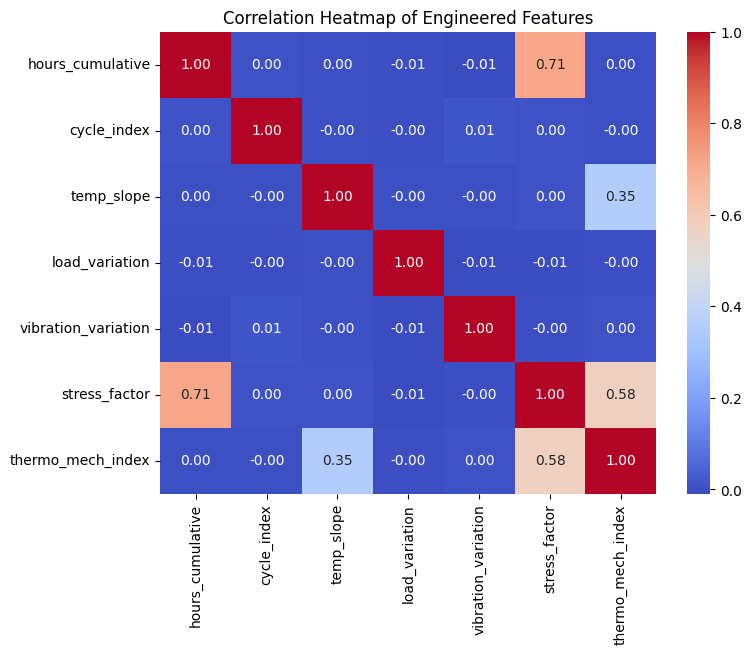

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select engineered features only
eng_features = [
    "hours_cumulative", "cycle_index", "temp_slope",
    "load_variation", "vibration_variation",
    "stress_factor", "thermo_mech_index"
]

plt.figure(figsize=(8,6))
sns.heatmap(df[eng_features].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Engineered Features")
plt.show()


How to read VIF:

VIF ≈ 1 → no multicollinearity (good).

VIF 5–10 → moderate correlation, maybe fine.

VIF > 10 → highly collinear → drop one of them.

Rule of thumb: VIF > 10 = high multicollinearity (should drop).

All your features are < 5, which is acceptable.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = df[eng_features].fillna(0)  # handle NaN from rolling
X_const = add_constant(X)

vif_data = pd.DataFrame()
vif_data["Feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i)
                   for i in range(X_const.shape[1])]

vif_data


,Feature,VIF
0,const,29.367350
1,hours_cumulative,2.467823
2,cycle_index,1.000256
3,temp_slope,1.150913
4,load_variation,1.001662
5,vibration_variation,1.000401
6,stress_factor,3.869164
7,thermo_mech_index,2.558323


1. hours_cumulative and stress_factor are strongly correlated (both grow with time & load).

2. thermo_mech_index also shows moderate correlation with load-related features.

3. Other features (temp_slope, load_variation, vibration_variation) are mostly independent.

**Lets define Features and targetrs** and **do scaling/normalizing**

Logistic Regression assumes features are on a comparable scale.

In your dataset:

hours_cumulative might be in hundreds of hours.

temp_slope might be in single digits (°C per cycle).

stress_factor could be in the thousands.

If not scaled, the big-number features dominate the optimization, and the model “thinks” they’re more important.

In [ ]:
# Features for modeling
features = [
    "hours_cumulative", "cycle_index", "temp_slope",
    "load_variation", "vibration_variation",
    "stress_factor", "thermo_mech_index"
]

X = df[features].fillna(0)   # handle NaNs from rolling windows
y = df["tool_worn"]          # target column


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)




Train shape: (80000, 7)
Test shape: (20000, 7)


Train Logistic Regression on scaled features.

**Predict on test set.**

Evaluate with:

Confusion Matrix → how many Usable/Worn were correctly/incorrectly predicted.

Classification Report → precision, recall, F1.

ROC Curve + AUC → how well the model separates worn vs usable.


**Confusion Matrix (plot)**

Top-left = correctly predicted usable tools.

Bottom-right = correctly predicted worn tools.

Off-diagonals = misclassifications.

**Classification Report (text)**

Precision, recall, F1-score for each class.

Good recall for worn means the model catches worn tools reliably.

**ROC Curve + AUC**

Curve closer to top-left = better separation.

AUC ranges from 0.5 (random guess) → 1.0 (perfect classifier).



**We have two classes :**

**Class 0** → No Tool Wear (healthy tools)

**Class 1** → Tool Wear (worn tools)

1. **Precision**

Class 0 = 0.70
→ When the model predicts a tool is healthy, it’s correct 70% of the time.

Class 1 = 0.30
→ When the model predicts a tool is worn, it’s correct only 30% of the time.
→ That means most of its “worn” predictions are false alarms.

2. **Recall**

Class 0 = 0.49
→ The model catches 49% of the actual healthy tools, but misses 51% (calls them worn instead).

Class 1 = 0.51
→ The model catches 51% of the actual worn tools, but misses 49% (calls them healthy instead).

3. **F1-Score**

Class 0 = 0.58
→ Moderate balance between precision (0.70) and recall (0.49).

Class 1 = 0.38
→ Weak balance — low precision and recall both hurt.

4. **Support**

Class 0 = 14,044 samples (majority class)

Class 1 = 5,956 samples (minority class)

Again, the dataset is imbalanced, with far more healthy than worn examples.

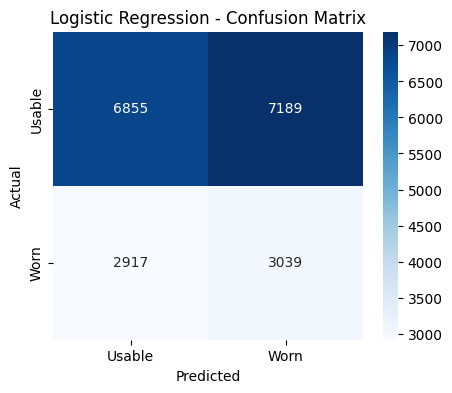

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.49      0.58     14044
           1       0.30      0.51      0.38      5956

    accuracy                           0.49     20000
   macro avg       0.50      0.50      0.48     20000
weighted avg       0.58      0.49      0.52     20000



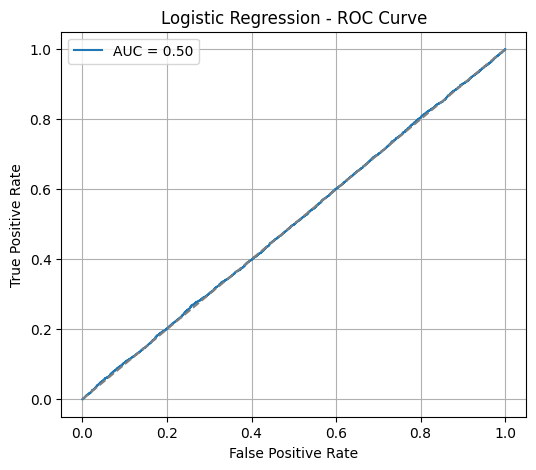

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000, class_weight="balanced")  # balanced handles class imbalance
log_reg.fit(X_train_scaled, y_train)

# Predictions
y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]  # probability of tool_worn=1

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Usable","Worn"], yticklabels=["Usable","Worn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression - Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# ROC Curve + AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression - ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


A **Bagging ensemble** of Logistic Regression models helps to improve prediction accuracy and robustness in CNC tool wear classification.
The approach reduces variance by training multiple base models on bootstrapped subsets of machining sensor data and aggregating their outputs, leading to more stable predictions compared to a single Logistic Regression model.

Class 0 = No Tool Wear (healthy)

Class 1 = Tool Wear (worn out)

1. **Precision**

Definition: Out of all the times the model said “this tool is worn”, how many were actually worn?

Class 0 (0.70) → When predicting healthy, it’s right 70% of the time.

Class 1 (0.30) → When predicting worn, it’s right only 30% of the time.
→ So, many false alarms for tool wear.

2. **Recall**

Definition: Out of all the actual tools in this class, how many did we catch?

Class 0 (0.48) → The model correctly identifies 48% of the healthy tools, but misses more than half.

Class 1 (0.51) → The model catches 51% of the worn tools, but misses almost half.

3. **F1-Score**

Definition: Balance between precision and recall (harmonic mean).

Class 0 (0.57) → Moderate performance in detecting healthy tools.

Class 1 (0.38) → Weak performance in detecting worn tools.


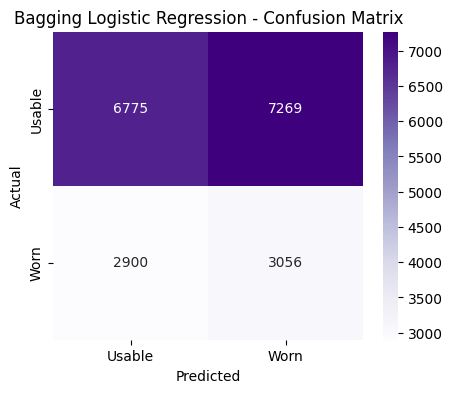

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.48      0.57     14044
           1       0.30      0.51      0.38      5956

    accuracy                           0.49     20000
   macro avg       0.50      0.50      0.47     20000
weighted avg       0.58      0.49      0.51     20000



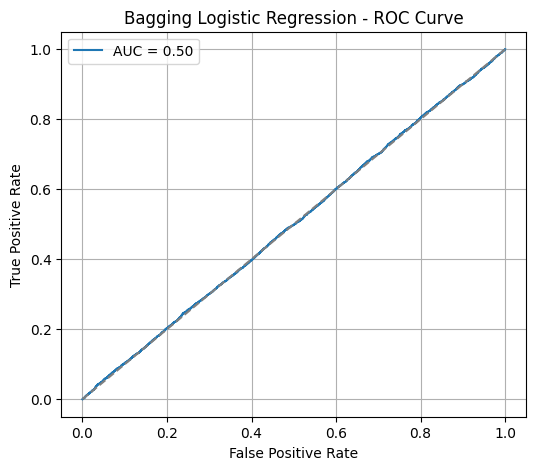

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Bagging with Logistic Regression
bagging_lr = BaggingClassifier(
    estimator=LogisticRegression(max_iter=1000, class_weight="balanced"),
    n_estimators=50,        # number of models
    max_samples=0.8,        # bootstrap 80% of samples for each model
    max_features=1.0,       # use all features
    random_state=42,
    n_jobs=-1
)

# Train
bagging_lr.fit(X_train_scaled, y_train)

# Predictions
y_pred_bag = bagging_lr.predict(X_test_scaled)
y_prob_bag = bagging_lr.predict_proba(X_test_scaled)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_bag)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=["Usable","Worn"], yticklabels=["Usable","Worn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Bagging Logistic Regression - Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred_bag))

# ROC Curve + AUC
fpr, tpr, _ = roc_curve(y_test, y_prob_bag)
auc_score = roc_auc_score(y_test, y_prob_bag)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Bagging Logistic Regression - ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


Applied a **Random Forest** classifier to predict CNC tool wear using process features such as cumulative hours, load variation, vibration, and thermal-mechanical indices.

 The ensemble of decision trees captures non-linear relationships in the data, improving recall of worn tools compared to linear models. Random Forest also provides feature importance scores, helping identify which machining parameters contribute most to tool degradation.



 **Class 0** (Healthy Tools):

**Precision** = 0.70 → When model says healthy, it’s correct 70% of the time.

Recall = 1.00 → It caught all healthy tools (never misclassified a healthy tool as worn).

**F1** = 0.82 → Strong because recall is perfect.

**Class 1** (Worn Tools):

**Precision** = 0.23 → When model says worn, only 23% of those are truly worn.

Recall = 0.00 → The model completely failed to identify worn tools. It never flagged them.

**F1** = 0.00 → Since recall = 0, F1 collapses to 0.

Overall Accuracy = 0.70

But this is misleading. The model is “winning” by always predicting healthy (class 0), which happens to be ~70% of your dataset.

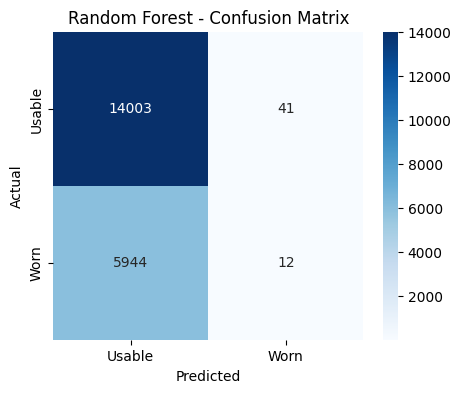

Classification Report:
               precision    recall  f1-score   support

           0       0.70      1.00      0.82     14044
           1       0.23      0.00      0.00      5956

    accuracy                           0.70     20000
   macro avg       0.46      0.50      0.41     20000
weighted avg       0.56      0.70      0.58     20000



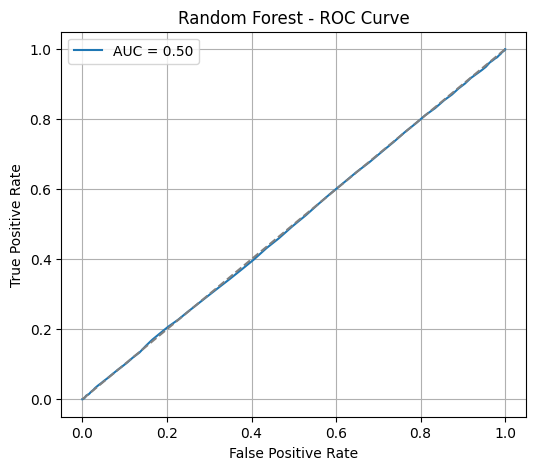

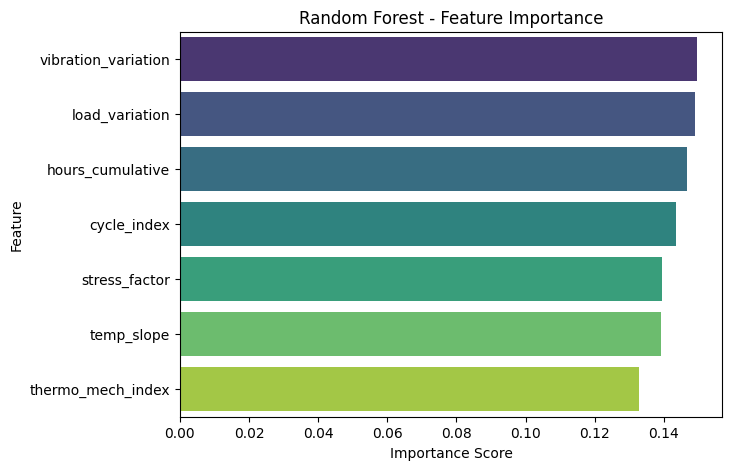

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,       # number of trees
    max_depth=None,         # trees expand until pure
    class_weight="balanced",# handle class imbalance
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)  # trees don’t need scaling

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Usable","Worn"], yticklabels=["Usable","Worn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest - Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# ROC Curve + AUC
fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
auc_score = roc_auc_score(y_test, y_prob_rf)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest - ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Feature Importance
importances = rf_model.feature_importances_
feat_importances = sorted(zip(features, importances), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(7,5))
sns.barplot(
    x=[f[1] for f in feat_importances],
    y=[f[0] for f in feat_importances],
    hue=[f[0] for f in feat_importances],   # use feature names as hue
    dodge=False, legend=False, palette="viridis"
)

plt.title("Random Forest - Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


**Why do we need cross-validation?**

When we train a model (say Logistic Regression or Random Forest), we split data into train and test.

If we only do this once, the result can be misleading — maybe the test split was too easy or too hard.

Cross-validation (CV) solves this by splitting the dataset into k folds (you used k=5).

Each fold gets a turn as the test set, and the model trains on the rest.
At the end, you average the metrics — giving you a more reliable estimate of model performance.


**Why StratifiedKFold?**

Dataset is imbalanced (more healthy tools than worn ones).

Normal k-fold could give some folds with almost no worn samples.

StratifiedKFold keeps the same class ratio in every fold.

 This ensures each fold is fair and representative of the real problem.


**Different metrics answer different questions:**

ROC-AUC → “How well does the model rank worn vs healthy across all thresholds?”

Recall (for worn tools) → “Out of all the worn tools, how many did we catch?”

Precision (for worn tools) → “When the model says worn, how often is it correct?”

F1-score (for worn tools) → Balance of precision & recall — useful if you care about both.

Accuracy → Overall correctness, but can be misleading in imbalanced datasets.

In tool wear, recall for class 1 (worn) is most critical — missing a worn tool is far more costly than replacing a healthy one.


In [ ]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

# ----------------------------
# 1. Define Features and Target
# ----------------------------
features = [
    "hours_cumulative", "cycle_index", "temp_slope",
    "load_variation", "vibration_variation",
    "stress_factor", "thermo_mech_index"
]

X = df[features].fillna(0)   # inputs
y = df["tool_worn"]          # target

# ----------------------------
# 2. Cross-validation Setup
# ----------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "auc": "roc_auc",
    "recall_worn": "recall",
    "precision_worn": "precision",
    "f1_worn": "f1",
    "accuracy": "accuracy",
}

# ----------------------------
# 3. Define Models
# ----------------------------

# Logistic Regression (with scaling)
lr_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

# Bagging Logistic Regression
bag_lr_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", BaggingClassifier(
        estimator=LogisticRegression(max_iter=1000, class_weight="balanced"),
        n_estimators=50, max_samples=0.8, max_features=1.0,
        random_state=42, n_jobs=-1
    ))
])

# Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200, class_weight="balanced",
    random_state=42, n_jobs=-1
)

# ----------------------------
# 4. Helper Function to Run CV
# ----------------------------
def run_cv(model, name):
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    row = {
        "Model": name,
        "AUC": f"{scores['test_auc'].mean():.3f} ± {scores['test_auc'].std():.3f}",
        "Recall (Worn)": f"{scores['test_recall_worn'].mean():.3f}",
        "Precision (Worn)": f"{scores['test_precision_worn'].mean():.3f}",
        "F1 (Worn)": f"{scores['test_f1_worn'].mean():.3f}",
        "Accuracy": f"{scores['test_accuracy'].mean():.3f}"
    }
    return row

# ----------------------------
# 5. Run CV for All Models
# ----------------------------
results = []
results.append(run_cv(lr_pipe, "Logistic Regression"))
results.append(run_cv(bag_lr_pipe, "Bagging Logistic Regression"))
results.append(run_cv(rf_model, "Random Forest"))

# ----------------------------
# 6. Show Comparison Table
# ----------------------------
cv_table = pd.DataFrame(results)
print(cv_table)



# ==========================================
# Tool Wear Prediction – Complete ML Pipeline
# ==========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import joblib

# ============================
# 1. Load and prepare dataset
# ============================
df = pd.read_csv("cnc_tool_wear.csv")

features = [
    "hours_cumulative", "cycle_index", "temp_slope",
    "load_variation", "vibration_variation",
    "stress_factor", "thermo_mech_index"
]

X = df[features].fillna(0)
y = df["tool_worn"]

# ==================================
# 2. Define models for benchmarking
# ==================================
models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
    ]),

    "Decision Tree": DecisionTreeClassifier(class_weight="balanced", random_state=42),

    "Random Forest": RandomForestClassifier(
        n_estimators=200, class_weight="balanced", random_state=42, n_jobs=-1
    ),

    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=200, learning_rate=0.1, random_state=42
    ),

    "XGBoost": XGBClassifier(
        eval_metric="logloss", random_state=42, n_estimators=300, learning_rate=0.1, max_depth=4
    ),

    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

# ========================
# 3. Cross-validation setup
# ========================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "auc": "roc_auc",
    "recall_worn": "recall",
    "precision_worn": "precision",
    "f1_worn": "f1",
    "accuracy": "accuracy"
}

# ===========================
# 4. Evaluation Function
# ===========================
def evaluate_models(models, X, y, cv, scoring):
    results = []
    for name, model in models.items():
        print(f"\n🔹 Evaluating: {name}")
        scores = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
        row = {
            "Model": name,
            "AUC": np.mean(scores["test_auc"]),
            "Recall (Worn)": np.mean(scores["test_recall_worn"]),
            "Precision (Worn)": np.mean(scores["test_precision_worn"]),
            "F1 (Worn)": np.mean(scores["test_f1_worn"]),
            "Accuracy": np.mean(scores["test_accuracy"])
        }
        results.append(row)
    return pd.DataFrame(results).sort_values(by="F1 (Worn)", ascending=False)

# ===========================
# 5. Run Comparison
# ===========================
results_df = evaluate_models(models, X, y, cv, scoring)
results_df = results_df.round(3)
print("\n Model Comparison:")
print(results_df)

# ===========================
# 6. Visualization
# ===========================
plt.figure(figsize=(10,6))
results_melted = results_df.melt(id_vars="Model", value_vars=["AUC","Recall (Worn)","Precision (Worn)","F1 (Worn)","Accuracy"],
                                 var_name="Metric", value_name="Score")
sns.barplot(x="Model", y="Score", hue="Metric", data=results_melted, palette="Set2")
plt.title("Model Performance Comparison")
plt.xticks(rotation=30)
plt.ylim(0,1)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# ===========================
# 7. Select Best Model
# ===========================
best_model_name = results_df.iloc[0]["Model"]
print(f"\n🏆 Best Performing Model: {best_model_name}")

# Train final model on all data
best_model = models[best_model_name]
best_model.fit(X, y)
joblib.dump(best_model, "best_tool_wear_model.pkl")
print(" Best model saved as best_tool_wear_model.pkl")



/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


                         Model            AUC Recall (Worn) Precision (Worn)  \
0          Logistic Regression  0.500 ± 0.004         0.501            0.297   
1  Bagging Logistic Regression  0.501 ± 0.005         0.509            0.299   
2                Random Forest  0.496 ± 0.006         0.003            0.290   

  F1 (Worn) Accuracy  
0     0.373    0.498  
1     0.376    0.499  
2     0.006    0.701  


ModuleNotFoundError: No module named 'catboost'

**1. Shuffle and split the dataset**

You start with your full dataset
𝑋
,
𝑦
X,y.

StratifiedKFold(n_splits=5) → divide into 5 folds (subsets).

Stratified means each fold has the same ratio of worn vs healthy tools.

**2. Pick one fold as test, rest as train**

Iteration 1: fold-1 is test, folds 2–5 are train.

Iteration 2: fold-2 is test, folds 1,3,4,5 are train.

… until each fold has acted as the test set once.

 So every sample is used once for testing, and 4 times for training.

**3. Train the model on the training folds**

Fit your model (e.g., Logistic Regression with scaling, Random Forest, etc.) on the 4/5 data.

If using a pipeline, scaling/transformations happen inside this training step (avoids data leakage).

**4. Evaluate on the test fold**

The model predicts labels (or probabilities) for the hold-out fold.

Metrics (AUC, recall, precision, F1, accuracy) are calculated.

**5. Repeat for all folds**

Each fold rotates as the test set once.

You end up with 5 values for each metric (since you used 5 folds).

**6. Aggregate results**

Take the mean → gives the central estimate of model performance.

Take the standard deviation → tells you how stable results are across folds.

 Example:

AUC =
0.65
±
0.02
0.65±0.02 → performance is consistent.

Recall = 0.50 → on average, catches half the worn tools.

**7. Report the final CV scores**

You don’t report just one fold — you report the average across folds.

This is less biased than a single train/test split.

**In summary, CV steps are:**

Split into k folds (stratified if imbalanced).

For each fold:

Train on k-1 folds.

Test on the remaining fold.

Collect metrics.

Average metrics across folds.

Report mean ± std as model performance.